In [1]:
from copy import deepcopy
import os
import random
import tempfile
import urllib.request

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import obonet
from pyvis.network import Network

In [2]:
random.seed(42)
np.random.seed(42)

In [3]:
G = nx.karate_club_graph()
degrees = [G.degree(v) for v in G]
max_degree = max(degrees)
print("Node  Club    Degree")
for v, d in zip(G, degrees):
    print(f'{v:3}  {G.nodes[v]["club"]:7}  deg({v})={d}')
club_color = {'Mr. Hi': 'green', 'Officer': 'orange'}
node_color = [club_color[G.nodes[v]['club']] for v in G]
node_alpha = [d / max_degree for d in degrees]
node_size = [int(300 * alpha) for alpha in node_alpha]

Node  Club    Degree
  0  Mr. Hi   deg(0)=16
  1  Mr. Hi   deg(1)=9
  2  Mr. Hi   deg(2)=10
  3  Mr. Hi   deg(3)=6
  4  Mr. Hi   deg(4)=3
  5  Mr. Hi   deg(5)=4
  6  Mr. Hi   deg(6)=4
  7  Mr. Hi   deg(7)=4
  8  Mr. Hi   deg(8)=5
  9  Officer  deg(9)=2
 10  Mr. Hi   deg(10)=3
 11  Mr. Hi   deg(11)=1
 12  Mr. Hi   deg(12)=2
 13  Mr. Hi   deg(13)=5
 14  Officer  deg(14)=2
 15  Officer  deg(15)=2
 16  Mr. Hi   deg(16)=2
 17  Mr. Hi   deg(17)=2
 18  Officer  deg(18)=2
 19  Mr. Hi   deg(19)=3
 20  Officer  deg(20)=2
 21  Mr. Hi   deg(21)=2
 22  Officer  deg(22)=2
 23  Officer  deg(23)=5
 24  Officer  deg(24)=3
 25  Officer  deg(25)=3
 26  Officer  deg(26)=2
 27  Officer  deg(27)=4
 28  Officer  deg(28)=3
 29  Officer  deg(29)=4
 30  Officer  deg(30)=4
 31  Officer  deg(31)=6
 32  Officer  deg(32)=12
 33  Officer  deg(33)=17


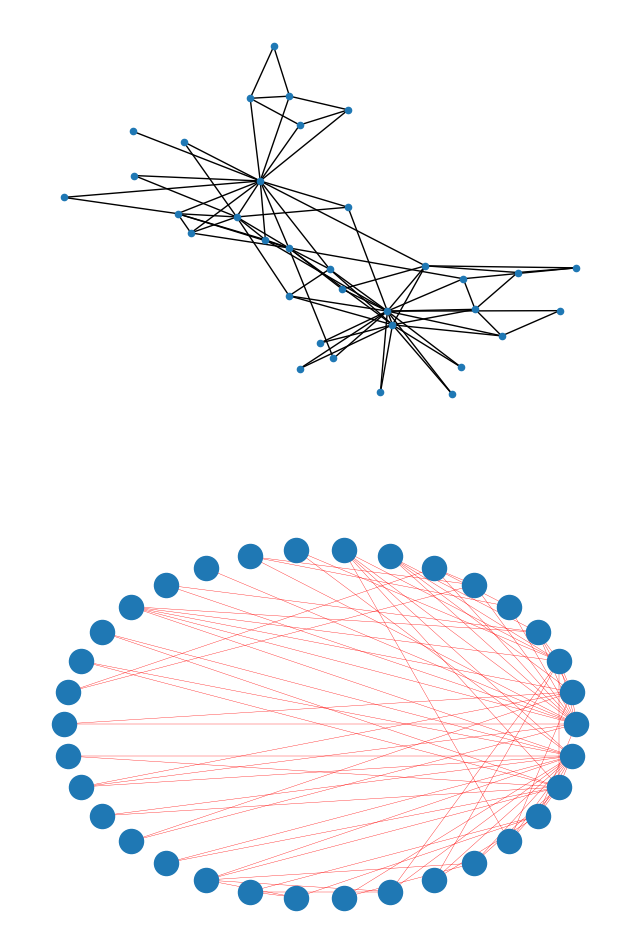

In [4]:
# Simple drawing
fig, ax = plt.subplots(2, 1, figsize=(8, 12))
nx.draw(G, ax=ax[0], node_size=20)  # nx.spring_layout is used by default
nx.draw(G, pos=nx.circular_layout(G), edge_color='red', width=0.25, ax=ax[1])

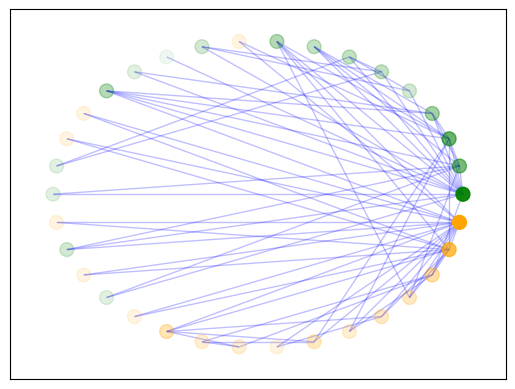

In [5]:
pos = nx.circular_layout(G)  # Same as nx.draw_circular
nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=100, alpha=node_alpha)
nx.draw_networkx_edges(G, pos, edge_color='blue', alpha=0.25)

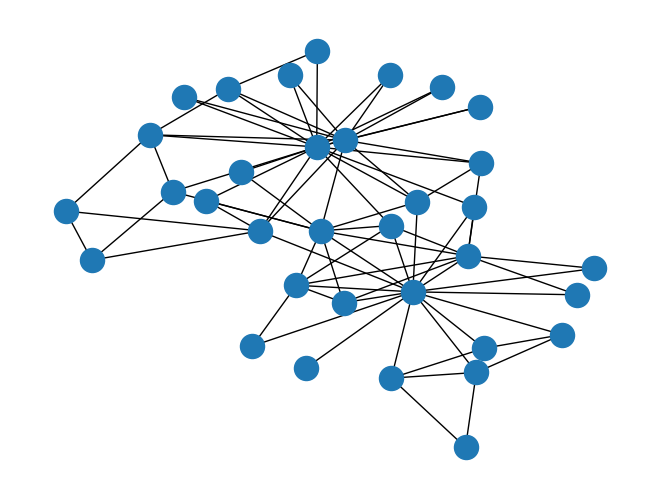

In [6]:
# Using GraphViz layouts
nx.draw(G, nx.nx_agraph.graphviz_layout(G))

In [7]:
def extract_phenotypic_abnormality_subgraph(graph: nx.MultiDiGraph) -> nx.MultiDiGraph:
    global_root_id = "HP:0000001"
    root_id = "HP:0000118"
    top_nodes = [child for (child, _) in graph.in_edges(global_root_id)]
    for node in top_nodes:
        if node == root_id:
            continue
        ancestors = nx.ancestors(graph, node) | {node}
        graph.remove_nodes_from(ancestors)
    graph.remove_node(global_root_id)
    del graph.nodes[root_id]["is_a"]
    return graph


def get_hpo(path="/opt/data/hp.obo", force=False):
    if not os.path.exists(path) or force:
        url = "http://purl.obolibrary.org/obo/hp.obo"
        _ = urllib.request.urlretrieve(url, path)
    graph = obonet.read_obo(path, ignore_obsolete=True)
    return extract_phenotypic_abnormality_subgraph(graph)


def save_hpo_as_gexf(graph, gexf_path='/opt/data/hp.gexf'):
    g = deepcopy(graph)
    for v in g:
        name = g.nodes[v]['name']
        g.nodes[v].clear()
        g.nodes[v]['name'] = name
    nx.write_gexf(g, gexf_path)    

In [8]:
%%time
graph = get_hpo(force=True)

CPU times: user 1.59 s, sys: 158 ms, total: 1.75 s
Wall time: 5.56 s


In [9]:
# GrpahVis-based visualization didn't want to work on raw data, so I used GEXF file
save_hpo_as_gexf(graph)
G = nx.read_gexf('/opt/data/hp.gexf')

In [10]:
# start_node = 'HP:0000750'
start_node = 'HP:0012759'
neural = nx.subgraph(G, nx.descendants(graph.reverse(copy=False), start_node) | {start_node})
neural.number_of_nodes()

45

In [11]:
for layer, nodes in enumerate(nx.topological_generations(neural)):
    for node in nodes:
        neural.nodes[node]["layer"] = layer
node_color = ["cyan" if n != start_node else "red" for n in neural]

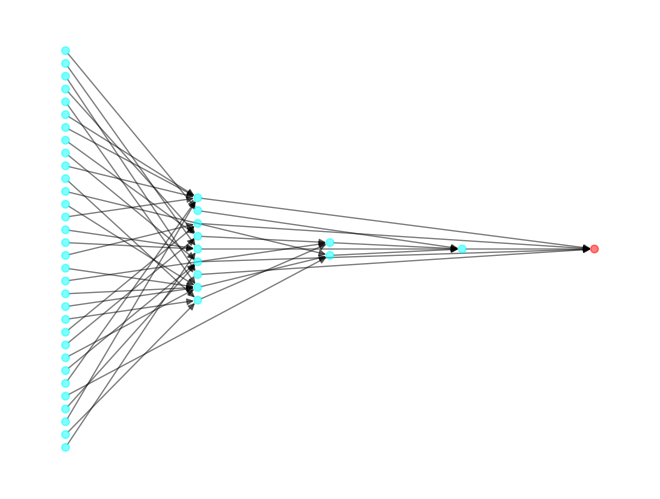

In [12]:
pos = nx.multipartite_layout(neural, subset_key="layer")
nx.draw(neural, pos=pos, with_labels=False, node_size=30, node_color=node_color, alpha=0.5)

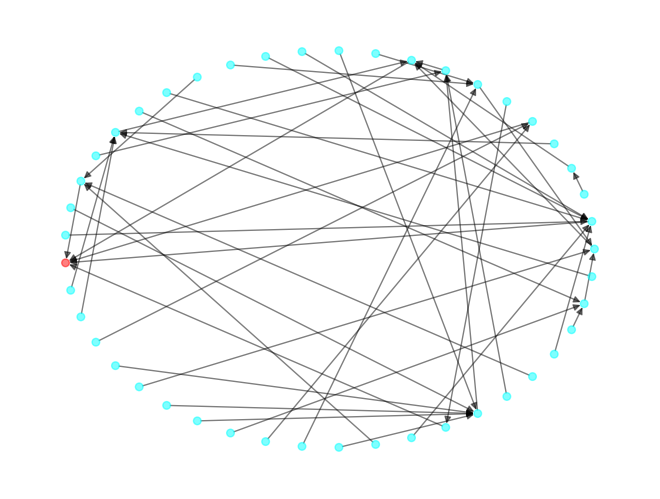

CPU times: user 362 ms, sys: 9.44 ms, total: 372 ms
Wall time: 123 ms


In [13]:
%%time
nx.draw(neural, nx.circular_layout(neural), node_size=30, with_labels=False, node_color=node_color, alpha=0.5)
plt.show()

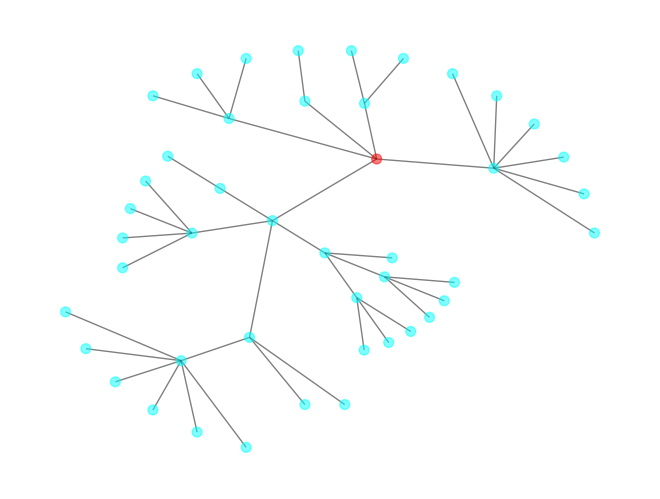

In [14]:
options = {"with_labels": False, "alpha": 0.5, "node_size": 50, "arrows": False, 
          "node_color": node_color}
pos = nx.nx_agraph.graphviz_layout(neural, prog="twopi", root='HP:0000750')
nx.draw(neural, pos, **options)

In [15]:
for n in neural:
    neural.nodes[n]['title'] = neural.nodes[n]['name']

In [16]:
nt = Network(height='1000px', notebook=True, cdn_resources='in_line', bgcolor="#222222", font_color="white",
             filter_menu=True, select_menu=True
            )
nt.from_nx(neural)
nt.show('_nx.html')

_nx.html


More plotting examples for other packages:
* [interactive network visualization with Bokeh](https://melaniewalsh.github.io/Intro-Cultural-Analytics/06-Network-Analysis/02-Making-Network-Viz-with-Bokeh.html)
* [interactive network visualization with Plotly](https://plotly.com/python/network-graphs/)
* [Plotting with iGraph](https://python.igraph.org/en/stable/tutorial.html#layouts-and-plotting)

Another option is [Gephi](https://gephi.org/) which is a very popular desktop app for graph visualization.